In [1]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

# Configure Notebook
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')
#plt.style.use('ggplot')
sns.set_context("talk")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import datasets

## import LTS data
lts_gpd = gpd.read_file('lts data/centerline_LTS_July2021.shp')

## import centrelines data
centrelines_gpd = gpd.read_file('centreline data/Centreline - Version 2.geojson')

## import all modes volume data
allmodes = pd.read_csv('all modes traffic data/tmcs_2010_2019.csv')

## Import the neighbourhood data and format it correctly.
fp_k, fp_k2 = 'Neighbourhood Data/neighbourhood-profiles-2016-csv (1).csv', \
              'Neighbourhood Data/Neighbourhoods.geojson'
neighbourhood_boundaries = gpd.read_file(fp_k2)

# Import bikelanes dataset
path_b = 'raw_data/bike-network-data-4326.geojson'
bikelane_gpd = gpd.read_file(path_b)

In [3]:
# sum turning movements for total intersection volume by mode
allmodes['car volume']=(allmodes['sb_cars_r']+allmodes['sb_cars_t']+allmodes['sb_cars_l']+
                        allmodes['nb_cars_r']+allmodes['sb_cars_t']+allmodes['sb_cars_l']+
                        allmodes['wb_cars_r']+allmodes['wb_cars_t']+allmodes['wb_cars_l']+
                        allmodes['eb_cars_r']+allmodes['eb_cars_t']+allmodes['eb_cars_l'])

allmodes['truck volume']=(allmodes['sb_truck_r']+allmodes['sb_truck_t']+allmodes['sb_truck_l']+
                          allmodes['nb_truck_r']+allmodes['sb_truck_t']+allmodes['sb_truck_l']+
                          allmodes['wb_truck_r']+allmodes['wb_truck_t']+allmodes['wb_truck_l']+
                          allmodes['eb_truck_r']+allmodes['eb_truck_t']+allmodes['eb_truck_l'])

allmodes['ped volume']=(allmodes['nx_peds']+allmodes['sx_peds']+allmodes['ex_peds']+
                        allmodes['wx_peds'])

allmodes['bike volume']=(allmodes['nx_bike']+allmodes['sx_bike']+allmodes['ex_bike']+
                         allmodes['wx_bike'])



          car volume   truck volume     ped volume    bike volume
count  226075.000000  226076.000000  226076.000000  226076.000000
mean      426.312551      16.060108      68.018149       6.182107
std       275.101772      18.067927     168.327611      16.171384
min         0.000000       0.000000       0.000000       0.000000
25%       231.000000       4.000000       5.000000       0.000000
50%       380.000000      11.000000      17.000000       1.000000
75%       570.000000      21.000000      52.000000       4.000000
max      3514.000000     370.000000    3736.000000     413.000000


<AxesSubplot:>

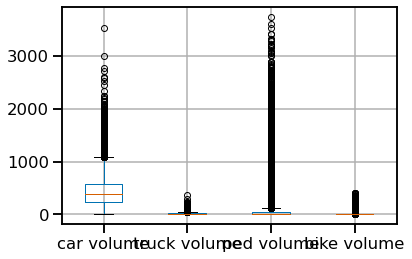

In [4]:
# plot distribution of volumes
print(allmodes[['car volume','truck volume','ped volume','bike volume']].describe())
allmodes[['car volume','truck volume','ped volume','bike volume']].boxplot()

Large spread in volumes is expected - busy intersections will have significantly higher volumes than idle intersections. No clear outliers.

In [5]:
# check what percentage of volumes are zero
print('car volume:', allmodes['car volume'].tolist().count(0)/len(allmodes)*100, '%')
print('truck volume:', allmodes['truck volume'].tolist().count(0)/len(allmodes)*100, '%')
print('ped volume', allmodes['ped volume'].tolist().count(0)/len(allmodes)*100, '%')
print('bike volume', allmodes['bike volume'].tolist().count(0)/len(allmodes)*100, '%')

car volume: 0.1986040216208565 %
truck volume: 7.386388768478136 %
ped volume 6.350463114500306 %
bike volume 48.62658020683127 %


We have lots of car volume data. No truck volume at 7% of intersections and no pedestrian volume at 6% of intersections - these numbers seem reasonable as we don't expect trucks and pedestrians at every intersection. No bike volume at 48% of intersections - this seems high. Could just be that people don't bike at these intersections, but we would probably expect intersections with pedestrians to have bikes as well. Let's see if we can model using car, truck, and pedestrian volumes given we have lots of data for these modes.

Our traffic volume dataset has multiple 15min readings for each intersection. Let's quickly check how many intersections we have data for.

In [6]:
len(allmodes['location'].unique())

3971

Looks like we have data for a decent number of intersections.

Our volume data was collected over 10 years from 2010 to 2019. It wouldn't be fair to compare/average data collected over different years - there is likely to be an inflationary effect i.e. traffic volumes increase each year. We need to convert volumes to "2019 equivalent" before we can compare them.

In [7]:
# create a duplicate dataframe we can manipulate
allmodes_dt = allmodes

In [8]:
# extract the year of data collection
allmodes_dt['year'] = pd.to_datetime(allmodes_dt['count_date']).dt.year

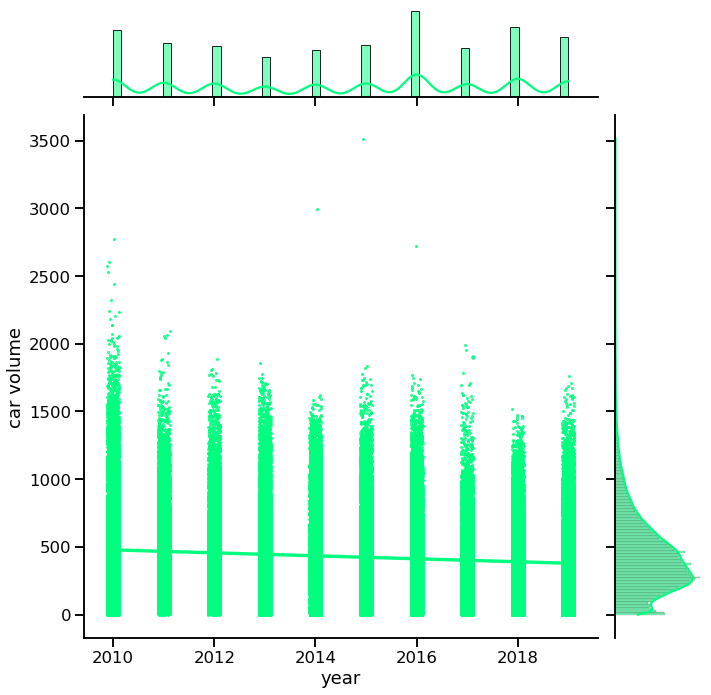

In [9]:
# let's try plotting all car volumes by year
ax = sns.jointplot(data=allmodes_dt, 
                   x='year', y='car volume', 
                   kind='reg', scatter_kws={"s": 4}, height=10, x_jitter=0.12, color='springgreen')
plt.show()

There doesn't seem to be a clear trend. Since we have plotted all car volume data it is misleading - we could have 2010 data from a busy intersection and 2019 data from an idle intersection and without context this would imply traffic was decreasing. 

Instead, let's assume traffic increases at the same rate as population. Between 2011 and 2016 census, Toronto's population increased from 5,583,064 to 5,928,040 (https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=CMACA&Code1=535&Geo2=PR&Code2=35&Data=Count&SearchText=Caledon%20East&SearchType=Begins&SearchPR=01&B1=All). We can calculate the compound annual growth rate (CAGR):

In [10]:
CAGR = (5928040/5583064)**(1/(2016-2011))-1
CAGR

0.01206336363744942

Therefore Toronto's population (and we assume traffic volume) increase at a rate of 1.2% per year. Let's calculate the 2019 equivalent traffic volumes for each mode.

In [11]:
allmodes_dt['car volume 2019eq'] = allmodes_dt.apply(lambda x: x['car volume']*(1+CAGR)**(2019-x['year']), axis=1)
allmodes_dt['truck volume 2019eq'] = allmodes_dt.apply(lambda x: x['truck volume']*(1+CAGR)**(2019-x['year']), axis=1)
allmodes_dt['ped volume 2019eq'] = allmodes_dt.apply(lambda x: x['ped volume']*(1+CAGR)**(2019-x['year']), axis=1)


Given we have multiple traffic volume readings for each intersection, let's use the median traffic volume for each intersection.

In [12]:
volumes = allmodes_dt.groupby('centreline_id').median().reset_index()[['centreline_id',
                                                                       'car volume 2019eq',
                                                                       'truck volume 2019eq',
                                                                       'ped volume 2019eq']]


We have our volumes dataset. Our LTS dataset includes properties for each road segment, including the FNODE (from intersection) and TNODE (to intersection). For each road, let's append the traffic volumes at the from and to intersections. The FNODE and TNODE values in the LTS dataset will line up with the centreline_id in our volumes dataset.

In [13]:
volumes

,centreline_id,car volume 2019eq,truck volume 2019eq,ped volume 2019eq
0,649.0,353.220114,10.560317,14.084444
1,8879.0,291.235402,38.691264,26.908650
2,9360.0,386.468761,13.476169,12.107495
3,105462.0,339.319267,30.819079,13.208177
4,106971.0,496.500000,13.803266,16.494318
...,...,...,...,...
3880,30112872.0,647.210369,20.051268,5.012817
3881,30113585.0,592.760510,6.257286,11.921227
3882,30119587.0,313.061783,7.256399,12.439541
3883,30122713.0,354.526920,12.439541,4.664828


In [14]:
# append volumes at from intersection
lts_volumes = pd.merge(lts_gpd, #left
                       volumes, #right
                       how='left',
                       left_on='FNODE',
                       right_on='centreline_id',
                       )

# append volumes at to intersection
lts_volumes = pd.merge(lts_volumes, #left
                       volumes, #right
                       how='left',
                       left_on='TNODE',
                       right_on='centreline_id',
                       )

# Convert LTS to str column for better plotting
lts_volumes['LTS str'] = lts_volumes['LTS'].astype('str')

Let's rename the columns so we remember which is which. "x" columns are the from intersection data, and "y" columns are the to intersection data. While we're at it, we can drop the centreline_id columns  - these are redundant since we have the FNODE and TNODE.

In [15]:
lts_volumes = lts_volumes.rename(columns={"car volume 2019eq_x": "car volume from",
                                          "car volume 2019eq_y": "car volume to",
                                          "truck volume 2019eq_x": "truck volume from",
                                          "truck volume 2019eq_y": "truck volume to",
                                          "ped volume 2019eq_x": "ped volume from",
                                          "ped volume 2019eq_y": "ped volume to",
                                         })
lts_volumes = lts_volumes.drop(columns=['centreline_id_x', 'centreline_id_y'])

Let's drop rows where we don't have volume data at both intersections.

In [16]:
lts_volumes = lts_volumes.dropna(subset=['car volume from', 'car volume to']).reset_index(drop=True)

The LTS dataset we imported classifed each road into one of four LTS classification: 1,2,3,4. For practical purposes, we don't really care about the actual classification, but rather if the road is high accessibility (LTS 1 and 2) or low accessibility (LTS 3 and 4). Let's add a binary classifier column that tells us if a road is high or low accessibility.

In [17]:
lts_volumes['high access'] = lts_volumes['LTS'].apply(lambda x: 1 if x <= 2 else 0)

In [18]:
lts_volumes

,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,car volume from,truck volume from,ped volume from,car volume to,truck volume to,ped volume to,LTS str,high access
0,67,30107530,1165,Bethridge Rd,13457060,13457328,0,1051.633271,30107530,2,0.012900,"LINESTRING (-79.56552 43.70915, -79.56719 43.7...",427.961238,19.933539,6.294802,348.267030,55.213066,1.061790,2,1
1,181,3135619,1243,Brown's Line,13470606,13470590,0,87.584880,3135619,4,0.000824,"LINESTRING (-79.54256 43.59577, -79.54291 43.5...",296.526817,14.851948,4.609225,304.768756,18.659312,2.073257,4,0
2,221,912782,458,Bloor St W,13469133,13469193,0,229.963631,912782,3,0.002753,"LINESTRING (-79.57078 43.63356, -79.57304 43.6...",396.222807,4.048253,7.084444,364.688651,9.684588,6.338234,3,0
3,291,30073849,2604,The West Mall,13470244,13470207,0,179.087399,30073849,4,0.001961,"LINESTRING (-79.55867 43.60835, -79.55870 43.6...",573.255517,19.873604,1.593608,446.876652,12.107495,41.275553,4,0
4,344,7487493,2353,Renforth Dr,13468615,13468558,0,87.067182,7487493,3,0.000832,"LINESTRING (-79.57024 43.63841, -79.57033 43.6...",66.796182,0.000000,2.024127,85.013323,0.000000,2.024127,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,59371,12313155,571,Eglinton Ave W,13458006,13458084,0,203.448264,12313155,3,0.002476,"LINESTRING (-79.42314 43.70151, -79.42556 43.7...",495.928160,13.969780,26.483222,785.276534,9.442203,92.907822,3,0
1585,59372,441102,24,Bayview Ave,13450213,13450012,0,156.558116,441102,4,0.001420,"LINESTRING (-79.38471 43.75075, -79.38487 43.7...",568.630436,18.884406,2.098267,800.745724,23.664650,1.100681,4,0
1586,59440,12763900,2852,Adelaide St W,13467056,13467106,-1,135.333590,12763900,1,0.001646,"LINESTRING (-79.38868 43.64820, -79.39029 43.6...",271.846058,14.183756,157.534133,336.504922,16.000000,324.500000,1,1
1587,59509,10223667,3780,King St W,13467505,13467592,0,217.461671,10223667,3,0.002651,"LINESTRING (-79.39505 43.64547, -79.39765 43.6...",428.981525,16.786138,605.000000,219.473609,7.432528,92.810999,3,0


Before test train splitting our data, we want to add the neighbourhood/k-mean cluster labels to the data so that spatial CV can be performed. While we're at it, let's add the population density of the neighbourhood each road is in as a feature.

In [19]:
# extract the neighbourhood id - we will use this to join the population densities
neighbourhood_boundaries['neigh_id'] = neighbourhood_boundaries['AREA_NAME'].str.extract('(\d+)')
neighbourhood_boundaries = neighbourhood_boundaries[['geometry','AREA_ID','neigh_id']]

# Make sure we have a consistent coordinate reference for our spatial join
lts_volumes_metre = lts_volumes.to_crs("EPSG:26917")
neighbourhood_metre = neighbourhood_boundaries.to_crs("EPSG:26917")

In [20]:
# Merge the two datasets, drop irrelevant information, fillnas if needed
lts_volumes_metre = gpd.sjoin(lts_volumes_metre, #left
                              neighbourhood_metre, #right
                              how='left',
                              op='within',
                             )
lts_volumes_metre['AREA_ID'] = lts_volumes_metre['AREA_ID'].fillna(101)
lts_volumes_metre['neigh_id'] = lts_volumes_metre['neigh_id'].fillna(0)
lts_volumes_metre = lts_volumes_metre.drop('index_right',axis=1)

In [21]:
# append population densities
densities = gpd.read_file(fp_k).iloc[[0,7],6:-1].T.reset_index().drop(columns=['index']).rename(columns={0: "neigh", 7: "pop_density"})
lts_volumes_metre = pd.merge(lts_volumes_metre, #left
                             densities, #right
                             how='left',
                             left_on='neigh_id',
                             right_on='neigh',
                             ).drop(columns=['neigh_id', 'neigh'])

# convert pop_density string to float
lts_volumes_metre['pop_density'] = lts_volumes_metre['pop_density'].str.replace(',', '').astype(float)


In [22]:
lts_volumes_metre

,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,car volume from,truck volume from,ped volume from,car volume to,truck volume to,ped volume to,LTS str,high access,AREA_ID,pop_density
0,67,30107530,1165,Bethridge Rd,13457060,13457328,0,1051.633271,30107530,2,...,427.961238,19.933539,6.294802,348.267030,55.213066,1.061790,2,1,2480131.0,1117.0
1,181,3135619,1243,Brown's Line,13470606,13470590,0,87.584880,3135619,4,...,296.526817,14.851948,4.609225,304.768756,18.659312,2.073257,4,0,2480045.0,2435.0
2,221,912782,458,Bloor St W,13469133,13469193,0,229.963631,912782,3,...,396.222807,4.048253,7.084444,364.688651,9.684588,6.338234,3,0,2480162.0,3614.0
3,291,30073849,2604,The West Mall,13470244,13470207,0,179.087399,30073849,4,...,573.255517,19.873604,1.593608,446.876652,12.107495,41.275553,4,0,2480079.0,2712.0
4,344,7487493,2353,Renforth Dr,13468615,13468558,0,87.067182,7487493,3,...,66.796182,0.000000,2.024127,85.013323,0.000000,2.024127,3,0,101.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,59371,12313155,571,Eglinton Ave W,13458006,13458084,0,203.448264,12313155,3,...,495.928160,13.969780,26.483222,785.276534,9.442203,92.907822,3,0,101.0,NaN
1585,59372,441102,24,Bayview Ave,13450213,13450012,0,156.558116,441102,4,...,568.630436,18.884406,2.098267,800.745724,23.664650,1.100681,4,0,2480128.0,2430.0
1586,59440,12763900,2852,Adelaide St W,13467056,13467106,-1,135.333590,12763900,1,...,271.846058,14.183756,157.534133,336.504922,16.000000,324.500000,1,1,2480154.0,8943.0
1587,59509,10223667,3780,King St W,13467505,13467592,0,217.461671,10223667,3,...,428.981525,16.786138,605.000000,219.473609,7.432528,92.810999,3,0,2480154.0,8943.0


We have some NaN population densities. We will fill these in with the median, but only after the train/test split to avoid data leakage.

Some roads are likely to have bike lanes, which will impact the bike accessibility. Let's add a binary label that indicates where a road has a bike lane or not.

In [23]:
# Merge the tags; We already know where the trails are, we just want the bikelanes on roads
bikelane_gpd['CNPCLASS'].unique()
streets = ['Fast Busy Street', 'Quiet Street' 'Fasy Busy Street']

bikelane_gpd = bikelane_gpd[bikelane_gpd['CNPCLASS'].isin(streets)]
print(bikelane_gpd.shape)
bikelane_gpd.head()
bikelane_gpd['INFRA_HIGHORDER'].unique()

(316, 28)


array(['Bike Lane', 'Bike Lane - Buffered', 'Cycle Track', 'Edge Line',
       None, 'Signed Route (No Pavement Markings)', 'Sharrows - Arterial',
       'Sharrows', 'Sharrows - Wayfinding', 'Contraflow Cycle Track'],
      dtype=object)

The dataset includes multiple types of bike lanes. We will only consider bike lanes and cycle tracks - the other types are unlikely to have a meaningful affect on accessibility.

In [24]:
bikelane_gpd[bikelane_gpd['INFRA_HIGHORDER'].isin(['Bike Lane','Bike Lane - Buffered','Cycle Track','Contraflow Cycle Track'])]

,_id,OBJECTID,SEGMENT_ID,INSTALLED,UPGRADED,PRE_AMALGAMATION,STREET_NAME,FROM_STREET,TO_STREET,ROADCLASS,...,DIR_HIGHORDER,INFRA_HIGHORDER,SEPA_HIGHORDER,SEPB_HIGHORDER,ORIG_HIGHORDER,BYLAWED,LAST_EDIT_DATE,UPGRADE_DESCRIPTION,Shape__Length,geometry
0,2525,1,1.0,2001,2007.0,Yes,Kilbarry Rd,Highbourne Rd,Oriole Pkwy,Collector - Residential,...,E,Bike Lane,Paint,None,Sharrows,Yes,2019-08-15T16:04:01,None,128.045211,"MULTILINESTRING ((-79.40351 43.69526, -79.4030..."
7,2532,8,8.0,2001,2018.0,Yes,Bloor St E,Parliament St,Prince Edward Viaduct,Major Arterial,...,E,Bike Lane - Buffered,Paint,None,Bike Lane,Yes,2019-08-15T16:04:01,None,666.425764,"MULTILINESTRING ((-79.37123 43.67189, -79.3711..."
10,2535,11,14.0,2001,2015.0,Yes,Hoskin Ave,St George St,Queens Park Cres W,Minor Arterial,...,E,Cycle Track,Bollards,None,Bike Lane,Yes,2019-08-15T16:04:01,None,526.024874,"MULTILINESTRING ((-79.39844 43.66411, -79.3969..."
30,2555,31,37.0,2001,2015.0,Yes,Lake Shore Blvd W,37 M E Fleeceline Rd,Humber Bay Park Rd W,Major Arterial,...,S,Bike Lane,Paint,None,Bike Lane,Yes,2019-08-15T16:04:01,None,311.918376,"MULTILINESTRING ((-79.48275 43.62093, -79.4829..."
54,2579,55,66.0,2001,2015.0,Yes,Queens Quay W,Martin Goodman Trl,Bathurst St,Collector - Residential,...,E,Cycle Track,Bollards,None,Bike Lane,Yes,2019-08-15T16:04:01,None,311.262875,"MULTILINESTRING ((-79.40061 43.63446, -79.3997..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,3779,1255,623.0,2001,0.0,Yes,Davenport Rd,Old Weston Rd,Spadina Rd,Minor Arterial,...,E,Bike Lane,Paint,None,None,Yes,2019-08-15T16:04:01,None,619.961325,"MULTILINESTRING ((-79.44211 43.67273, -79.4426..."
1255,3780,1256,NaN,0,NaN,No,Davenport Rd,Foundry Ave,St Clarens Ave,Minor Arterial,...,E,Bike Lane,None,None,None,None,2019-08-15T16:04:01,None,220.379255,"MULTILINESTRING ((-79.44749 43.67170, -79.4483..."
1256,3781,1257,623.0,2001,0.0,Yes,Davenport Rd,Old Weston Rd,Spadina Rd,Minor Arterial,...,E,Bike Lane,Paint,None,None,Yes,2019-08-15T16:04:01,None,566.707055,"MULTILINESTRING ((-79.43465 43.67429, -79.4359..."
1257,3782,1258,NaN,0,NaN,No,Davenport Rd,Mc Farland Ave,Bristol Ave,Minor Arterial,...,E,Bike Lane,None,None,None,None,2019-08-15T16:04:01,None,301.861292,"MULTILINESTRING ((-79.43953 43.67332, -79.4410..."


In [25]:
# Merge the bikelane features info to the features frame.
bikelane_gpd_m = bikelane_gpd[['INFRA_HIGHORDER','geometry']].to_crs("EPSG:26917")
bikelane_gpd_m['geometry'] = bikelane_gpd_m['geometry'].buffer(20)

lts_volumes_metre = gpd.sjoin(lts_volumes_metre, #left
                              bikelane_gpd_m, #right
                              how='left',
                              op='within',
                             ).drop(columns=['index_right']).rename(columns={"INFRA_HIGHORDER": "bike lane"})

lts_volumes_metre['bike lane']=lts_volumes_metre['bike lane'].apply(lambda x: 0 if pd.isnull(x) else 1)
                                    
lts_volumes_metre

,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,truck volume from,ped volume from,car volume to,truck volume to,ped volume to,LTS str,high access,AREA_ID,pop_density,bike lane
0,67,30107530,1165,Bethridge Rd,13457060,13457328,0,1051.633271,30107530,2,...,19.933539,6.294802,348.267030,55.213066,1.061790,2,1,2480131.0,1117.0,0
1,181,3135619,1243,Brown's Line,13470606,13470590,0,87.584880,3135619,4,...,14.851948,4.609225,304.768756,18.659312,2.073257,4,0,2480045.0,2435.0,0
2,221,912782,458,Bloor St W,13469133,13469193,0,229.963631,912782,3,...,4.048253,7.084444,364.688651,9.684588,6.338234,3,0,2480162.0,3614.0,0
3,291,30073849,2604,The West Mall,13470244,13470207,0,179.087399,30073849,4,...,19.873604,1.593608,446.876652,12.107495,41.275553,4,0,2480079.0,2712.0,0
4,344,7487493,2353,Renforth Dr,13468615,13468558,0,87.067182,7487493,3,...,0.000000,2.024127,85.013323,0.000000,2.024127,3,0,101.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,59371,12313155,571,Eglinton Ave W,13458006,13458084,0,203.448264,12313155,3,...,13.969780,26.483222,785.276534,9.442203,92.907822,3,0,101.0,NaN,0
1585,59372,441102,24,Bayview Ave,13450213,13450012,0,156.558116,441102,4,...,18.884406,2.098267,800.745724,23.664650,1.100681,4,0,2480128.0,2430.0,0
1586,59440,12763900,2852,Adelaide St W,13467056,13467106,-1,135.333590,12763900,1,...,14.183756,157.534133,336.504922,16.000000,324.500000,1,1,2480154.0,8943.0,0
1587,59509,10223667,3780,King St W,13467505,13467592,0,217.461671,10223667,3,...,16.786138,605.000000,219.473609,7.432528,92.810999,3,0,2480154.0,8943.0,0


This dataset is ready for modelling. Let's split the dataset into the train and test datasets.

In [26]:
# Do a 80/20 test train split and save these to a csv
from sklearn.model_selection import train_test_split

# stratify the split across the LTS labels
train, test = train_test_split(lts_volumes_metre, test_size=0.2, stratify=lts_volumes_metre['LTS'])

# write to csv files
train.to_csv('allmodes_train.csv')
test.to_csv('allmodes_test.csv')